In [6]:
pip install tensorflow opencv-python numpy matplotlib scikit-learn

Found 1757 images belonging to 2 classes.
Found 439 images belonging to 2 classes.

Class indices: {'without_mask': 0, 'with_mask': 1}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6859 - loss: 0.6062 - val_accuracy: 0.8383 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8702 - loss: 0.2926 - val_accuracy: 0.8292 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8953 - loss: 0.2699 - val_accuracy: 0.8565 - val_loss: 0.2950 - learning_rate: 0.0010
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8896 - loss: 0.2486 - val_accuracy: 0.8292 - val_loss: 0.3345 - learning_rate: 0.0010
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9073 - loss: 0.2198 - val_accuracy: 0.8633 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9087 - loss: 0.2210 - val_accuracy: 0.8815 - val_loss: 0.2825 - learning_rate: 5.0000e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9032 - loss: 0.2062 - val_accur

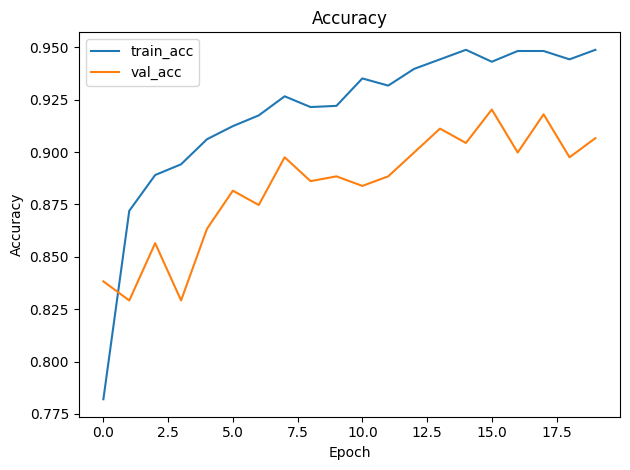

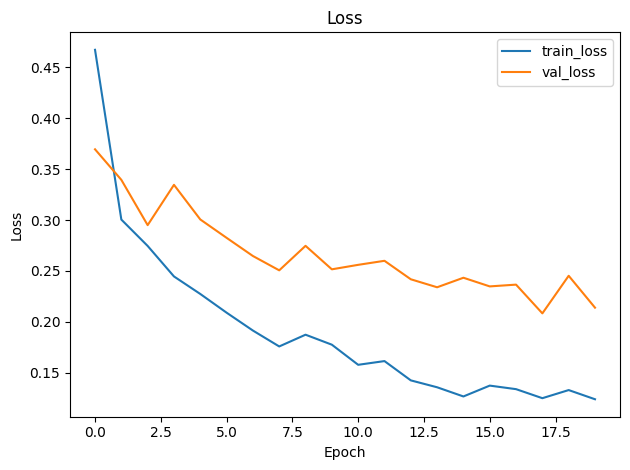

In [2]:
# Step 2: Train the model
import os, json, math
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
import tensorflow as tf
import os

DATA_DIR = "data"
IMG_SIZE = 128
BATCH_SIZE = 32
VAL_SPLIT = 0.2
EPOCHS = 20
CLASS_ORDER = ["without_mask", "with_mask"]
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=VAL_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED,
    classes=CLASS_ORDER
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED,
    classes=CLASS_ORDER
)

print("\nClass indices:", train_gen.class_indices)
def build_model(img_size=IMG_SIZE):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_model()
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/mask_detector.best.keras"
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True)
]

steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)
val_steps = math.ceil(val_gen.samples / BATCH_SIZE)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    verbose=1
)

model.save("mask_detector.keras")
with open("class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.savefig("accuracy.png")

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.savefig("loss.png")

print("\nSaved: mask_detector.keras, class_indices.json, accuracy.png, loss.png")


In [3]:
# Step 3: Real-time detection
import json
import cv2
import numpy as np
import tensorflow as tf

MODEL_PATH = "mask_detector.keras"
CLASS_MAP_PATH = "class_indices.json"
IMG_SIZE = 128
model = tf.keras.models.load_model(MODEL_PATH)
with open(CLASS_MAP_PATH, "r") as f:
    class_indices = json.load(f)
idx_to_class = {v: k for k, v in class_indices.items()}
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
cap = cv2.VideoCapture(0)
def predict_label(face_img_bgr):
    face = cv2.resize(face_img_bgr, (IMG_SIZE, IMG_SIZE))
    face = face.astype("float32") / 255.0
    face = np.expand_dims(face, axis=0)
    prob = model.predict(face, verbose=0)[0][0]
    pred_idx = 1 if prob >= 0.5 else 0
    pred_name = idx_to_class[pred_idx]
    return pred_name, prob

while True:
    ok, frame = cap.read()
    if not ok:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        roi = frame[y:y+h, x:x+w]
        pred_name, prob = predict_label(roi)

        if pred_name == "with_mask":
            label = f"Mask ({prob:.2f})"
            color = (0, 200, 0)
        else:
            label = f"No Mask ({1-prob:.2f})"
            color = (0, 0, 255)

        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Face Mask Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

# Step 4: Sanity check
import os
from collections import Counter

DATA_DIR = "data"
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("Found class folders:", classes)

counts = {}
for cls in classes:
    folder = os.path.join(DATA_DIR, cls)
    num = sum(1 for f in os.listdir(folder)
              if os.path.isfile(os.path.join(folder, f)) and not f.startswith("."))
    counts[cls] = num
print("Image counts:", counts)


Found class folders: ['.ipynb_checkpoints', 'without_mask', 'with_mask']
Image counts: {'.ipynb_checkpoints': 0, 'without_mask': 1111, 'with_mask': 1085}
